# Variational Quantum Eigensolvers

# ANALYSING TRADE-OFFS IN SYMMETRY-PRESERVING ANSATZ CIRCUITS FOR THE SCALABLE VARIATIONAL QUANTUM EIGENSOLVER ALGORITHM.

VQE - hybrid classical-quantum algorithm that can find the ground state energy of various quantum systems.

Has applications in quantum chemistry, where resources to classically simulate molecular wavefunctions increase exponentially with size of molecule.

True speedups in computational chemistry are still far off and dependant on development of large fault-tolerant quantum computers, VQEs can already be used to determine ground state energy of smaller molecules to a high degree of accuracy

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

In [13]:
from typing import Optional, Union, Callable, cast
import matplotlib.pyplot as plt
import numpy as np

from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance

from qiskit_nature.results import ElectronicStructureResult

from qiskit_nature.drivers import UnitsType, Molecule, QMolecule
from qiskit_nature.drivers.second_quantization import PySCFDriver, ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper

from qiskit_nature.circuit.library import HartreeFock, UCC, UCCSD

from qiskit.opflow.primitive_ops import Z2Symmetries

from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.algorithms import VQEUCCFactory
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP, COBYLA


### Overview

System is represented by a complex-valued wavefunction, and energy is associated with Hamiltonian $\mathbb{H}$, a matrix with eigenvalues that represent possible energies of the system.

System's groudn state is eigenstate of the Hamiltonian with lowest eigenvalue.

$\mathcal{H}\ket{\psi_g} = E_g\ket{\psi_g}$

$E_g = \frac{ \bra{\psi_g}|\mathcal{H}|\ket{\psi_g} }{ \braket{\psi_g}{\psi_g} }$

$E_g \leq \frac{ \bra{\psi}|\mathcal{H}|\ket{\psi} }{ \braket{\psi}{\psi} }$

VQE leverages this inequality by parameterizing quantum state used to evaluate energy expectation, and varationally updating these parameters on a classical computer to find tight upper bound to the ground state.

### Algorithm

* Parameterized quantum circuit prepares trialground state using some initial parameters values
* A quantum measurement circuit estimates energy expectation in this trial state.
* Classical optimization algorithm updates parameters to idealy decrease energy expectation of the next trail state.
* Algorithm is iterates until energy expectation converges to some value, which is taken as the approx ground state energy.

### Challenges

* Number of parameters required t prepare arbitrary quantum states increases problematically with system size, challenging the classical optimizer.

### Solutions

* reduce number of parameters, hence reduce algorithmic search space.

### Classical Optimizers

Responsible for determining parameter updates, thus for generating the new variational trial states.

* Gradient Descent - identifying energy expectation as const function to be minimized, but has tendency of being stuch in local minima and has relatively high number of required quantum circuit evaluations. (poor optimizer for VQE).

Popular optimizers for noise-free models i.e statevector simulations on classical computers. .e.g:
* Nelder-Mead method
* Sequential Least Squares Programming (SLSQP)
* Constrained Optimization by Linear Optimization (COBYLA) - being more efficient at the expense of fewer(just one) energy expectation evaluations per iteration.

VQE on physical quantum coputers incorporating noise models often involves more nuanced optimization schemes.

### Hamiltonian mapping

How wavefunction of a molecule can be mapped onto qubit states of a quantum computer.

General Hamiltonian for a quantum molecular system: (very intuitive)

$$\mathcal{\hat{H}} = - \sum_i \frac{\nabla^2_i}{2} - \sum_{i, I} \frac{Z_I}{|r_i - R_I|} + \sum_{i\neq j} \frac{1}{2|r_i - r_j|}$$

where: H = kinetic energy - electron-nucleus interaction + electron-electron interaction

Where:

$i$ and $j$ denote electrons,

$I$ denotes nuclei,

$Z$ is the atomic number of nuclei $I$,

$r$ is position of the electron $i$, $j$,

$R$ is position of each nucleus, which is fixed in space in accordance with the Bohr-Oppenheimer approximation.

The $\textbf{second quantization}$ Hamiltonian in which electrons are treated as excitations in an electron field, will ultimately prove more useful in our effort to encode probelm onto quantum copmuter:

$\begin{align}
\mathcal{\hat{H}} = \sum_{p,q} h_{pq}a^\dagger_p a_q + \frac{1}{2}\sum_{p,q,r,s}h_{pqrs}a^\dagger_p a^\dagger_q a_r a_s
\end{align}$

The $a^\dagger$ operators (creation operator) in each term "excite" electron to orbitals $p$ and $(p, q)$ respectively. The $a$ operator (annihilation operator) in each term $de-excites$ electron from orbitals $q$ and $(r, s)$ respectively.

The $h$ terms are coefficients known as the one an two-electron integrals and can be calculated relatively eficciently  in terms of a small set of orbital basis states on a classical computer.

We will restrict ourselves to single- and double-electron excitations to obtain a workable approximation of the more complicated true physical system.

There are 3 common mappings that can be used to produce a Hamiltonian for distinguishable fermions i.e. qubits from a Hmailtonian for indistinguishable fermions i.e. electrons:
* Jordan-Wigner mapping
* Parity mapping
* Bravyi-Kitaev mapping

All the mappings produce a Hamitonian of the form:

$\begin{equation}
\mathcal{\hat{H}} = \sum_j \alpha_j (\prod_i \hat{\sigma^j_i})
\end{equation}$

This is to say the Hamiltonian will be a linear combination of products of Pauli matrices (with $i$ denoting qubit being acted upon) which can be executed on a quantum computer.

Given a trial state, the energy expectation may be evaluated by measuring this superposition of Pauli operators, as below:

$E(\vec{\theta}) = \sum^N_j \alpha_j \bra{\psi(\vec{\theta})} \prod_i \sigma_i^j \ket{\psi(\vec{\theta})}$

### Parameterized Wavefunction Ansatz

Among most common wavefunction ansatz is the Unitary Coupled-CLuster Single and Double excitation (UCCSD) ansatz, used in foundational VQE paper by Perruzo et al.

UCCSD is constructed by applying an exponentiated single and double-electron excitation operator to an initial state, commonly chossen to be the Hartree-Fock mean-field wavefunction (an unentangled state that decently approximates the ground state):

$
\begin{align}
\ket{\psi(\theta)} = e^({\vec{T} - \vec{T}^\dagger}) \ket{\phi}\\\\
\hat{T} = \sum_{i\in virt, j\in occ} t^j_i \hat{a}_i^\dagger + \sum_{i, j \in virt, k, l \in occ} t^{kl}_{ij} \hat{a}_i^\dagger \hat{a}_j^\dagger \hat{a}_k \hat{a}_l
\end{align}
$

Where:

"virt" denotes unoccupied orbitals,

"occ" denotes occupied orbitals,

$a\dagger$ creation operators excite electrons and $a$ annihilation operators de-excite electrons to/from orbiatls,

t coefficients are the tunable parameters that are fed into classical optimizer.

The $T$ operator is then converted via one of the 3 mappings into as effective Hamiltoniann operator on qubits, which may be subsequently executed on a quantum copmuter.

### Chemistry-Inspired Ansatz

* UCCSD - UCC wit Singles and Doubles
* UpCCD - Unitary Pair UCCD
* OO-UCC - Orbital Optimized UCC
* DUCC - Double UCC


### Hardware Efficient Ansatz

* Symmetry Preserving State Preparation
* Qubit Coupled Cluster Method

### Energy

The hartree (symbol: Eh or Ha), also known as the Hartree energy, is the unit of energy in the Hartree atomic units system, named after the British physicist Douglas Hartree. Its CODATA recommended value is Eh = 4.3597447222071(85)×10−18 J[1] = 27.211386245988(53) eV.[2]

The hartree energy is approximately the electric potential energy of the hydrogen atom in its ground state and, by the virial theorem, approximately twice its ionization energy; the relationships are not exact because of the finite mass of the nucleus of the hydrogen atom and relativistic corrections.

The hartree is usually used as a unit of energy in atomic physics and computational chemistry: for experimental measurements at the atomic scale, the electronvolt (eV) or the reciprocal centimetre (cm−1) are much more widely used. 

(Courtesy: Wikipedia: https://en.wikipedia.org/wiki/Hartree)

### Building a VQE in Qiskit

VQE in Python using Qiskit, as open-source SDK for working with quantum computers, to find ground state energy and corresponding interatomic spearaton for several small molecules: diatomic hydrogen ($H_2$), lithium hydride ($LiH$), ionic helium hydride ($HeH+$) and hydroxide ($OH-$)

---
* First the molecule structure was specified as a string in xyz coordinates, lithium hydroxide woudl specify as "Li 0.0 0.0 0.0; H 0.0 0.0 d" where d is the interatomic distance.

For two-atom molecules, the z-coordinate of the second atom was varied to determine ground state energy as a function of interatomic distance.

* A PySCF driver was initialized with this molecule specification, creating a data structure representing the molecule along with several useful calculated attributes, including the nuclear repulsion energy - a quantity later added to the VQE-determined electron energy to obtain the total molecular energy.

The PySCF molecular data structure was then provided as input to the ElectronicStructureProblem class in Qiskit-Nature module. This class determines the Hamiltoninan of the molecule in terms of second-quantization operators, calculating the one- and two-electron integral coefficients discussed previously and returning the electronic operator in the form:


Where:

"+" is the excitation operator

"-" is the de-excitation operator

"I" is the identity operator

"N" is the number operator (de-excitation followed by excitation)

This operator was then converted into a qubit operator using the class qiskit_nature.converters.second_quantization,QubitConverter, with the mapping type set to the Jordan-Wigner transformation, yielding a summation of Pauli operator products:



Note that the number of qubits needed to execute algorithm s equal to number of second quantization operators, which is defined as the number of molecular spin orbitals considered.

* Next,the Hartree-Fock initial state preparation circuit and the UCCSD variational unitary transformation circuit. (with HF as its initial state) were retrieved from a library of optimized circuits in the qiskit_nature.circuits.library module, being sure to pass the Jordan-Wigner QubitConverter object created earlier as an argument to each circuit for consistency.

Finally, these were all supplied to the VQE class in the module qiskit.algorithms, which simulated the UCCSD variational circuit repeatedly on a Qiskit Aer statevector backend to solve for the minimum eigenvalue of the qubit Hamiltonina, using the SLSQP classical optimizer to calculate parameter updates.

This algorithm was repeated for intermolecular separations ranging between 0.2 and 2 Angstroms (~0.1 nanometres), storing the minimum energy as determined by the VQE at each iteration.

In [34]:
state_sim = StatevectorSimulator()

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit_nature.algorithms import ExcitedStatesEigensolver, VQEUCCFactory

# vqe_energies = []

class MolecularVQE:
    def __init__(self):
        # H2
        self.molecule_name = "H 0.0 0.0 0.0; H 0.0 0.0 "
        self.backend = QuantumInstance(state_sim)
        self.optimizer = SLSQP(maxiter=500)
        self.vqe = VQE(
            ansatz = None,
            quantum_instance = self.backend,
            optimizer = self.optimizer
        )
        
        
    def get_qubit_op(self, dist, mapper="parity"):
        # Use PySCF, a classical computational chemistry software
        # package, to compute the on-body and two-body integrals in
        # electronic-orbital basis, necessary to form the Fermionic operator
        
        driver = PySCFDriver(
            atom = self.molecule_name + str(dist),
            # unit = UnitsType.ANGSTROM,
            # charge = 0,
            # spin = 0,
            # basis = "sto3g"
        )
        
        #molecule = Molecule(
        #    geometry=[
        #        ["H", [0.0, 0.0, 0.0]],
        #        ["H", [0.0, 0.0, 0.735]]
        #    ],
        #    charge=0,
        #    multiplicity=1
        #)
        
        #driver = ElectronicStructureMoleculeDriver(
        #    basis = "sto3g",
        #    driver_type=ElectronicStructureDriverType.PYSCF
        #)

        qmolecule = driver.run()    # returns ElectronicStructureDriverResult
        transformer = FreezeCoreTransformer()
        qmolecule = transformer.transform(qmolecule)
    
        es_problem = ElectronicStructureProblem(driver)
        
        if mapper == "jw":
            qubit_converter = QubitConverter(mapper=JordanWignerMapper())
        elif mapper == "parity":
            qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
            
        return (es_problem, qubit_converter)
    
    def run(self):
        numpy_solver = NumPyMinimumEigensolver()
        
        # distances = np.arange(0.3, 2.0, 0.05)
        distances = np.arange(0.65, 1.0, 0.05)
        exact_energies = []
        vqe_energies = []
        
        n = len(distances)
        i = 1
        
        for dist in distances:
            print("Distance {}/{}".format(i, n))
            i += 1
            
            es_problem, qubit_converter = self.get_qubit_op(dist)
            second_q_ops = es_problem.second_q_ops()
            
            # Hamiltonian
            main_op = second_q_ops[0]
            
            #mine z2sym = Z2Symmetries.find_Z2_symmetries(second_q_ops)
            qubit_op = qubit_converter.convert(
                main_op,
                num_particles = es_problem.num_particles,
                #sector_locator = es_problem.symmetry_sector_locator(None, qubit_converter)
            )
            
            # aux_ops = qubit_converter.convert_match(
            #     second_q_ops[1:]
            # )
            
            # q_molecule_transformed = cast(QMolecule, es_problem.molecule_data_transformed)
            # num_molecular_orbitals = q_molecule_transformed.num_molecular_orbitals
            # num_particles = (q_molecule_transformed.num_alpha, q_molecule_transformed.num_beta)
            # num_spin_orbitals = 2 * num_molecular_orbitals
            
            num_particles = es_problem.num_particles
            num_spin_orbitals = es_problem.num_spin_orbitals
            
            
            # initial state is Hartree-Fock state
            initial_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
            
            # UCCSD ansatz for unitary update
            ansatz = UCCSD()
            ansatz.qubit_converter = qubit_converter
            ansatz.num_particles = num_particles
            ansatz.num_spin_orbitals = num_spin_orbitals
            ansatz.initial_state = initial_state
            
            self.vqe.ansatz = ansatz
            solver = self.vqe
            
            # solver = VQEUCCFactory(
            #     quantum_instance=self.backend,
            #     optimizer=self.optimizer,
            #     ansatz=ansatz,
            #     initial_state=initial_state
            # )
            
            uccsd_excited_states_calculation = ExcitedStatesEigensolver(qubit_converter, solver)
            print(uccsd_excited_states_calculation)
            # uccsd_ground_excited_states_properties = uccsd_excited_states_calculation.solve(es_problem)
            
            print("Computing the minimum eigenvalue...")
            
            # Approximate minimum eigensolver using VQE
            vqe_result = solver.compute_minimum_eigenvalue(qubit_op)
            print(vqe_result)
            # print(np.real(vqe_result.eigenvalue) + nuclear_repulsion_energy)
            
            
            # vqe_energies.append(np.real(vqe_result.eigenvalue) + nuclear_repulsion_energy)
            
            vqe_energies.append(np.real(vqe_result.eigenvalue))
            
        return (distances, vqe_energies, exact_energies)
        # return self.vqe.ansatz

### Results

Demonstrate close correspondence between experimentally determined ground state energies and the ground state energies determined using VQEs. The ground state interatmoic distance was dtermined by finding the minimum on the plot of VQE ground state energy against interatomic distance.

Find a theoretical curve of ground stte energy against interatomic distance - determined by diagonalizing the molecule Hamiltonian directly using NumpyMinimumEigensolver - check if it coincides with VQE curve.

In [35]:
vqe = MolecularVQE()
res = vqe.run()

# res.draw("mpl")



Distance 1/7
Computing the minimum eigenvalue...
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 13,
    'eigenstate': array([-1.06023981e-08-9.02056208e-17j,  9.95433931e-01+5.85952419e-16j,
       -9.54530748e-02-1.51164432e-16j, -3.37124193e-08-5.55111512e-17j]),
    'eigenvalue': (-1.9440235703061848+0j),
    'optimal_parameters': {   ParameterVectorElement(t[1]): 3.371241934912606e-08,
                              ParameterVectorElement(t[2]): 0.09559862244051313,
                              ParameterVectorElement(t[0]): 1.060239817902326e-08},
    'optimal_point': array([1.06023982e-08, 3.37124193e-08, 9.55986224e-02]),
    'optimal_value': -1.9440235703061848,
    'optimizer_evals': None,
    'optimizer_time': 0.23056364059448242}
Distance 2/7
Computing the minimum eigenvalue...
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 13,
    'eigenstate': array([-1.47916226e-08-1.73472348e-16j,  9.94507056e-01+1.88466006e-16j,
       -1.04669551e-01-

Min Distance: 0.65


Min Energy: -1.9440235703061848


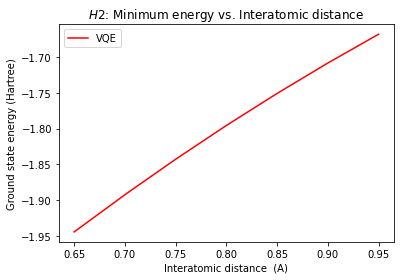

In [36]:
plt.plot(res[0], res[1], c="r", label="VQE")


# plt.rc("text", usetext=True)
plt.title(r"$H2$: Minimum energy vs. Interatomic distance")
plt.ylabel("Ground state energy (Hartree)")
plt.xlabel("Interatomic distance  (A)")
plt.legend()
# plt.show()

idx = res[1].index(min(res[1]))
dist, min_energy = res[0][res[1].index(min(res[1]))], min(res[1])
print("Min Distance: {}\n\n".format(dist))
print("Min Energy: {}".format(min_energy))